In [1]:
from utils_v1 import *


In [2]:
from icecream import ic

import numpy as np
from src.dataset import (
    MultipleDates,
    PA, PADeforestationTime, PADistanceMap, PAMultipleDates,
    MTDeforestationTime,
    MTMultipleDates
)

# from src.dataset_legacy import MTDeforestationTime
from src import training_generator as generator
from src.patchesHandler import PatchesHandler, PatchesHandlerMultipleDates, PatchesHandlerEvidential

from src.trainer.evidential import TrainerEvidential, TrainerEvidentialUEO
import src.trainer.evidential as evidential

from mpl_toolkits.axes_grid1 import make_axes_locatable

import cv2
from src import metrics as _metric


In [3]:
from enum import Enum
UncertaintyMethod = Enum('Predictor', 'pred_var MI pred_entropy KL pred_entropy_single evidential')
uncertaintyMethod = "evidential"


In [4]:

config = {
	"training": False,
	"learning_rate": 1e-3, # 1e-3
	#"learning_rate": 1e-5, # 1e-3	
	"weights": [0.1, 0.9, 0],
	"save_probabilities": False,
	"loadInference": False,
	"addPastDeforestationInput": True,
	"inference_times": 1,
	"Uncertainty": {
		"annealing_step": 10*375 # 1875, 10*375*10
	},
	"uncertainty_method": uncertaintyMethod,
	"evidence_function": evidential.relu_evidence
}

'''
if config["training"] == True:
	dates = [2017, 2018]
else:
	dates = [2018, 2019]
if config["training"] == True:
	dates = [2018, 2019]
else:
	dates = [2019, 2020]
'''
dates = [2018, 2019]
dataset = PAMultipleDates(dates = dates, # dates = [2017, 2018, 2019]. [2018, 2019]. [2015, 2016, 2017, 2018]
	addPastDeforestationInput = config['addPastDeforestationInput'],
	borderBuffer = 2)	
# dates = [2019, 2020]
# dataset = MTMultipleDates(dates = dates, # dates = [2016,2017,2018,2019]
# 	addPastDeforestationInput = config['addPastDeforestationInput'],
# 	borderBuffer = 2)	
# dataset = MTDeforestationTime()	
# [2016, 2017, 2018]

ic(dates)


if issubclass(type(dataset), MultipleDates):
	patchesHandler = PatchesHandlerEvidential(
		dataset)
else:
	patchesHandler = PatchesHandler()

# exp = 170
# exp = 155
exp = 155 # relu
# exp = 171 # softsign
exp = 173
# exp = 186

# if config["training"] == True:
# trainer = TrainerEvidentialUEO(config, dataset, patchesHandler)
trainer = TrainerEvidential(config, dataset, patchesHandler)

trainer.defineExperiment(exp)


ic| list(self.date_ids): [0]
ic| self.image_channels: [[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20]]
ic| dates: [2018, 2019]
ic| self.input_image_shape: 21
ic| self.dataset.image_channels: [[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20]]


In [5]:
exp

173

In [6]:
trainer.setExperimentPath()
trainer.createLogFolders()

In [7]:
# ic(type(dataset), exp, dataset.dates)


In [8]:

trainer.loadLabel()

D:/Jorge/datasets/deforestation/Para/deforestation_past_years.tif
Loaded deforestation past years


ic| np.unique(deforestation_past_years, return_counts=True): (array([   0, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017,
                                                                    2018, 2019, 2020, 2021], dtype=uint16),
                                                              array([132185553,   3150503,   4571354,    864429,    903608,   1299506,
                                                                      2477971,   1561686,   1459696,    969060,    644976,   2209014,
                                                                      2100204,   5257014,   3514616], dtype=int64))


Label where deforestation past years is actual date (2019) = 1


ic| np.unique(deforestation_past_years, return_counts=True): (array([   0, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017,
                                                                    2018, 2019, 2020, 2021], dtype=uint16),
                                                              array([132185553,   3150503,   4571354,    864429,    903608,   1299506,
                                                                      2477971,   1561686,   1459696,    969060,    644976,   2209014,
                                                                      2100204,   5257014,   3514616], dtype=int64))


Past deforestation different from 0 (no deforestation)


ic| np.unique(deforestation_past_years, return_counts=True): (array([   0, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017,
                                                                    2018, 2019, 2020, 2021], dtype=uint16),
                                                              array([132185553,   3150503,   4571354,    864429,    903608,   1299506,
                                                                      2477971,   1561686,   1459696,    969060,    644976,   2209014,
                                                                      2100204,   5257014,   3514616], dtype=int64))


Past deforestation before 2008 is 2
D:/Jorge/datasets/deforestation/deforestation_before_2008/deforestation_before_2008_para.tif


ic| np.unique(label_past_deforestation_before_2008, return_counts=True): (array([  0, 215], dtype=uint8), array([124211220,  38957970], dtype=int64))
ic| np.unique(deforestation_past_years, return_counts=True): (array([   0, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017,
                                                                    2018, 2019, 2020, 2021], dtype=uint16),
                                                              array([132185553,   3150503,   4571354,    864429,    903608,   1299506,
                                                                      2477971,   1561686,   1459696,    969060,    644976,   2209014,
                                                                      2100204,   5257014,   3514616], dtype=int64))
ic| label_per_date.shape: (17730, 9203, 1)


Mask label shape:  
 (17730, 9203, 1) 
 Unique values:  
 [0 1 2]


In [9]:

# Creating tile mask
trainer.createTrainValTestTiles()


Tiles size:  3546 2300
Mask size:  (17730, 9200)


In [10]:

trainer.label_mask.dtype

dtype('uint8')

In [11]:

trainer.getLabelCurrentDeforestation()

In [12]:

trainer.loadInputImage()

ic| image_stack.shape: (17730, 9203, 21)


Image shape:  (17730, 9203, 21)
mask:  (17730, 9200)
image stack:  (17730, 9200, 21)
ref : (17730, 9200, 1)


In [13]:

np.unique(trainer.image_stack[...,0], return_counts=True)

(array([0.        , 0.08333334, 0.16666667, 0.25      , 0.33333334,
        0.4166667 , 0.5       , 0.5833334 , 0.6666667 , 0.75      ,
        0.8333334 , 0.9166667 , 1.        ], dtype=float32),
 array([104050616,   2209014,    644713,    968315,   1458862,   1560879,
          2477424,   1299508,    903419,    864429,   4570932,   3150455,
         38957434], dtype=int64))

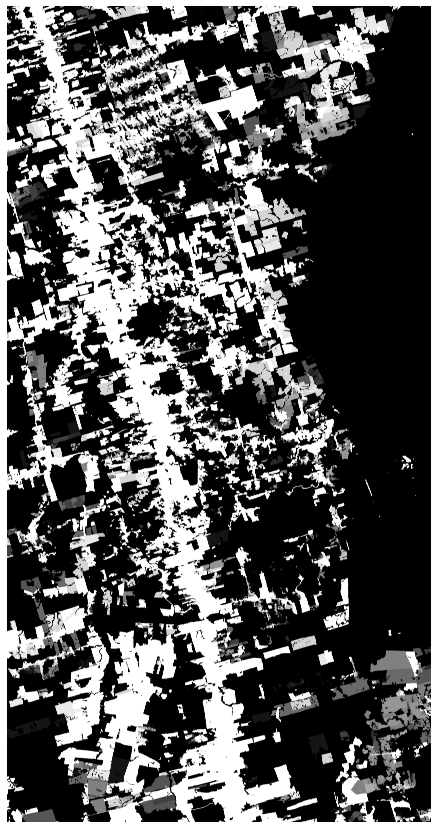

In [14]:

trainer.logger.plotFigure(trainer.image_stack[...,0], 
    name='image_stack_first_channel', cmap=plt.cm.gray, savefig=False)

In [15]:

trainer.getImageChannels()

ic| self.image_stack.shape: (17730, 9200, 21)
ic| self.channels: 21


In [16]:

trainer.getTrainValTestMasks()

Training tiles:  [1, 3, 5, 8, 11, 13, 14, 20]
Validation tiles:  [6, 19]
Test tiles:  [2, 4, 7, 9, 10, 12, 15, 16, 17, 18]


In [17]:

if config["training"] == True:
    # Extracting patches from the idx matrix
    trainer.createIdxImage()


In [18]:
if config["training"] == True:
    trainer.extractCoords()

In [19]:
if config["training"] == True:
    trainer.trainTestSplit()

In [20]:
if config["training"] == True:
    trainer.label_mask.shape

In [21]:
if config["training"] == True:
    if type(dataset) != PADeforestationTime and type(dataset) != MTDeforestationTime:
        trainer.logger.plotFigure(trainer.label_mask[...,-1], 
            name='Reference', cmap=plt.cm.gray, savefig=False)

    else:
        trainer.logger.plotFigure(trainer.label_mask[...,-1], 
            name='Reference', cmap=plt.cm.gray, savefig=False)



In [22]:
if config["training"] == True:
    np.unique(trainer.label_mask)

In [23]:
if config["training"] == True:
    print(trainer.coords_train)

In [24]:
if config["training"] == True:
    trainer.retrieveSamplesOfInterest()

In [25]:
if config["training"] == True:
    inputSnipShow = True

In [26]:
if config["training"] == True:
    if inputSnipShow == True:
        trainer.snipDataset(idx = 2800)


In [27]:
if config["training"] == True:
    if inputSnipShow == True:
        trainer.snipDataset(idx = 97)


In [28]:
if config["training"] == True:
    if inputSnipShow == True:

        trainer.snipDataset(idx = 1200)

In [29]:
if config["training"] == True:
    if inputSnipShow == True:

        trainer.snipDataset(idx = 400)

In [30]:
if config["training"] == True:
    trainer.getGenerators()


In [31]:
if config["training"] == True:
    trainer.fixChannelNumber()

In [32]:
if config["training"] == True:
    print(trainer.path_exp)

In [33]:
if config["training"] == True:
    print(trainer.channels)

In [34]:
if config["training"] == True:
    print(trainer.image_stack.shape)

In [35]:
# trainer.weights = [0.01, 0.99, 0]
trainer.weights

[0.1, 0.9, 0]

### Evidential metrics

In [36]:
if config["training"] == True:
    trainer.train()

In [37]:
if config["training"] == True:
    trainer.plotHistory()


In [38]:
if config["training"] == True:
    trainer.plotLossTerms()

In [39]:
if config["training"] == True:
    trainer.plotAnnealingCoef()

In [40]:
def draw_EDL_results(K, history):
    # train_acc1, train_ev_s, train_ev_f, test_acc1, test_ev_s, test_ev_f 
    # calculate uncertainty for training and testing data for correctly and misclassified samples
    '''
    K: known classes
    '''
    train_u_succ = K / (K+np.array(history['evidential_success']))
    train_u_fail = K / (K+np.array(history['evidential_fail']))
    test_u_succ  = K / (K+np.array(history['val_evidential_success']))
    test_u_fail  = K / (K+np.array(history['val_evidential_fail']))
    
    f, axs = plt.subplots(2, 2)
    f.set_size_inches([10,10])
    
    axs[0,0].plot(history['evidential_success'],c='r',marker='+')
    axs[0,0].plot(history['evidential_fail'],c='k',marker='x')
    axs[0,0].set_title('Train Data')
    axs[0,0].set_xlabel('Epoch')
    axs[0,0].set_ylabel('Estimated total evidence for classification') 
    axs[0,0].legend(['Correct Clasifications','Misclasifications'])
    
    axs[0,1].plot(train_u_succ,c='r',marker='+')
    axs[0,1].plot(train_u_fail,c='k',marker='x')
    axs[0,1].plot(history['acc'],c='blue',marker='*')
    axs[0,1].set_title('Train Data')
    axs[0,1].set_xlabel('Epoch')
    axs[0,1].set_ylabel('Estimated uncertainty for classification')
    axs[0,1].legend(['Correct clasifications','Misclasifications', 'Accuracy'])
    
    axs[1,0].plot(history['val_evidential_success'],c='r',marker='+')
    axs[1,0].plot(history['val_evidential_fail'],c='k',marker='x')
    axs[1,0].set_title('Test Data')
    axs[1,0].set_xlabel('Epoch')
    axs[1,0].set_ylabel('Estimated total evidence for classification') 
    axs[1,0].legend(['Correct Clasifications','Misclasifications'])
    
    axs[1,1].plot(test_u_succ,c='r',marker='+')
    axs[1,1].plot(test_u_fail,c='k',marker='x')
    axs[1,1].plot(history['val_acc'],c='blue',marker='*')
    axs[1,1].set_title('Test Data')
    axs[1,1].set_xlabel('Epoch')
    axs[1,1].set_ylabel('Estimated uncertainty for classification')
    axs[1,1].legend(['Correct clasifications','Misclasifications', 'Accuracy'])
    

In [41]:
if config["training"] == True:
    draw_EDL_results(trainer.class_n, trainer.history.history)

    plt.figure(5)
    plt.plot(trainer.history.history['evidential_success'],c='r',marker='+')
    plt.plot(trainer.history.history['evidential_fail'],c='k',marker='x')
    plt.title('Train Data')
    plt.xlabel('Epoch')
    plt.ylabel('Estimated total evidence for classification') 
    plt.legend(['Correct Clasifications','Misclasifications'])


In [42]:
trainer.image_stack.shape

(17730, 9200, 21)

In [43]:
if type(trainer.dataset) != PADeforestationTime and type(trainer.dataset) != MTDeforestationTime:
    trainer.patchesHandler.dataset.image_channels[-1]

In [44]:
if issubclass(type(dataset), MultipleDates):
	trainer.channels = trainer.patchesHandler.input_image_shape
	trainer.image_stack = trainer.image_stack[..., trainer.patchesHandler.dataset.image_channels[-1]]
	trainer.label_mask = trainer.label_mask[...,-1]

In [45]:
trainer.image_stack.shape

(17730, 9200, 21)

In [46]:
trainer.setPadding()

-30.0 -16.0


In [47]:
trainer.infer()

ic| self.path_models+ '/' + self.method +'_'+str(0)+'.h5': 'D:/Jorge/datasets/deforestation/experiments/exp173/models/resunet_0.h5'


time:  0


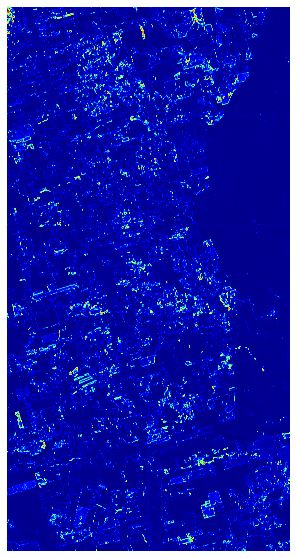

In [48]:
trainer.logger.plotFigure(trainer.u_reconstructed, 
            name='Uncertainty', cmap='jet', savefig=False, figsize=(10,10))

In [49]:
trainer.loadPredictedProbabilities()


In [50]:
trainer.prob_rec.shape

(17760, 9216)

In [51]:
trainer.getMeanProb()

In [52]:
trainer.logger.getStats(trainer.mean_prob)

ic| np.min(value): 0.0046187807
    np.mean(value): 0.030163825
    np.max(value): 0.96274173


In [53]:
ic(trainer.mean_prob.shape)

ic| trainer.mean_prob.shape: (17760, 9216)


(17760, 9216)

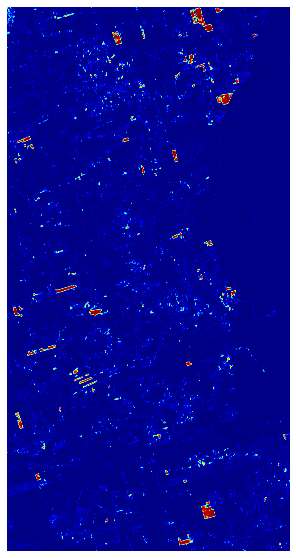

In [54]:
trainer.unpadMeanProb()
trainer.logger.plotFigure(trainer.mean_prob, 
            name='Mean predicted probability', figsize=(10,10), cmap='jet', savefig=False)

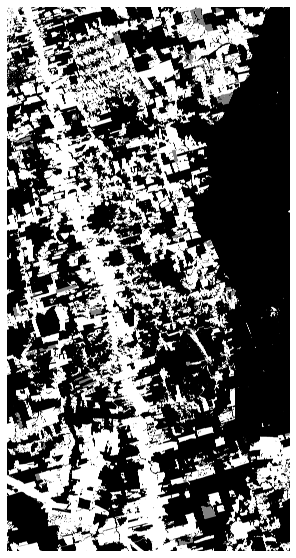

In [55]:
trainer.logger.plotFigure(trainer.label_mask, 
            name='Reference mask', figsize=(10,10), cmap=plt.cm.gray, savefig=True)

In [56]:
trainer.squeezeLabel()

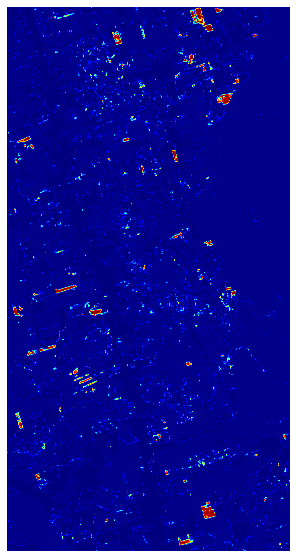

In [57]:
trainer.setMeanProbNotConsideredAreas()
trainer.logger.plotFigure(trainer.mean_prob, 
            name='Mean predicted probability', figsize=(10,10), cmap='jet', savefig=False)

In [58]:
trainer.logger.getStats(trainer.mean_prob)

ic| np.min(value): 0.0
    np.mean(value): 0.022795338
    np.max(value): 0.96274173


In [59]:
print(trainer.label_mask.shape)

(17730, 9200)


In [60]:
trainer.getLabelTest()

(54236371,)
(array([0, 1], dtype=uint8), array([53470765,   765606], dtype=int64))


In [61]:
trainer.getMAP()

90.16


In [62]:
trainer.prob_rec.shape

(17760, 9216)

In [63]:
trainer.preprocessProbRec()
print(trainer.prob_rec.shape)

(17760, 9216, 1)


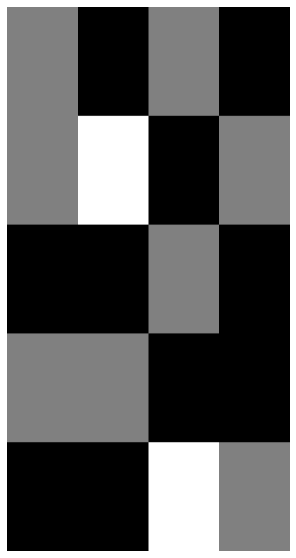

In [64]:
trainer.logger.plotFigure(trainer.mask_tr_val, 
            name=trainer.dataset.site + trainer.title_name + ' Train val mask.png', figsize=(10,10), savefig=False)

In [65]:
trainer.getLabelCurrentDeforestation()

In [66]:
trainer.applyProbabilityThreshold()

(17730, 9200)
(array([0., 1.], dtype=float32), array([161233790,   1882210], dtype=int64))


ic| self.predicted_unpad.shape: (17730, 9200)
    self.predicted.shape: (17730, 9200)


In [67]:
trainer.getTestValues()

ic| predicted_test.shape: (81558000,)
ic| predicted_test.shape: (54236371,)


In [68]:
trainer.removeSmallPolygons()

ic| np.unique(predicted, return_counts=True): (array([0., 1.], dtype=float32), array([161233790,   1882210], dtype=int64))
    np.unique(predicted_larger_than_min_area, return_counts=True): (array([0., 1.], dtype=float32), array([161411932,   1704068], dtype=int64))
ic| np.unique(ignored_polygons, return_counts=True): (array([0., 1.], dtype=float32), array([162937858,    178142], dtype=int64))


In [69]:
trainer.calculateMetrics()

ic| self.f1: 86.03, self.precision: 88.85, self.recall: 83.38


In [70]:
trainer.getValidationValuesForMetrics()
trainer.calculateMetricsValidation()

ic| self.label_mask_val.shape: (16311600,)
ic| self.label_mask_val_valid.shape: (9431090,)
ic| f1_val: 85.47
    precision_val: 83.29
    recall_val: 87.77
    mAP_val: 89.49


In [71]:
calculateMAPWithoutSmallPolygons = False
if calculateMAPWithoutSmallPolygons == True:
    trainer.calculateMAPWithoutSmallPolygons()

In [72]:
trainer.getErrorMask()

(array([0., 1.], dtype=float32), array([162578078,    537922], dtype=int64))


In [73]:
'''

import types

trainer.getErrorMaskToShowRGB = types.MethodType(getErrorMaskToShowRGB, trainer)
'''


'\n\nimport types\n\ntrainer.getErrorMaskToShowRGB = types.MethodType(getErrorMaskToShowRGB, trainer)\n'

In [74]:
trainer.getErrorMaskToShowRGB()

[0. 1.]


In [75]:
predicted_unpad_to_show = trainer.predicted_unpad.copy()

predicted_unpad_to_show[trainer.label_mask == 2] = 0
print(np.unique(predicted_unpad_to_show))

[0. 1.]


In [76]:
predicted_unpad_to_show.shape

(17730, 9200)

In [77]:

'''
trainer.logger.plotFigure = types.MethodType(trainer.logger.plotFigure, trainer)
'''

'\ntrainer.logger.plotFigure = types.MethodType(trainer.logger.plotFigure, trainer)\n'

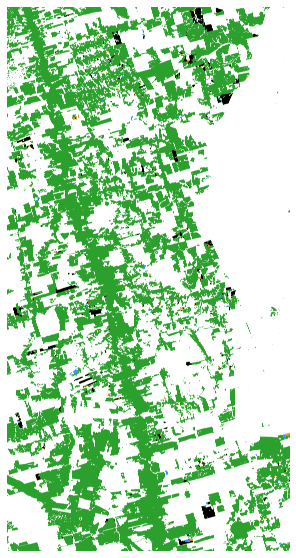

In [78]:
trainer.logger.plotFigure(trainer.error_mask_to_show_rgb[...,::-1], 
            name=trainer.dataset.site + trainer.title_name + ' error mask color.png', 
            figsize=(10,10), savefig=True, dpi=300)

In [79]:
trainer.setUncertainty()

In [80]:
trainer.getValidationValues2()
trainer.getTestValues2()

ic| self.label_mask.shape: (17730, 9200)
ic| self.mask_amazon_ts.shape: (17730, 9200)
ic| self.label_mask_test.shape: (81558000,)
ic| self.error_mask_test.shape: (54147698,)


In [81]:
trainer.getUncertaintyToShow()
trainer.logger.getStats(trainer.uncertainty_to_show)


ic| np.min(value): 0.0
    np.mean(value): 0.042114858
    np.max(value): 1.0


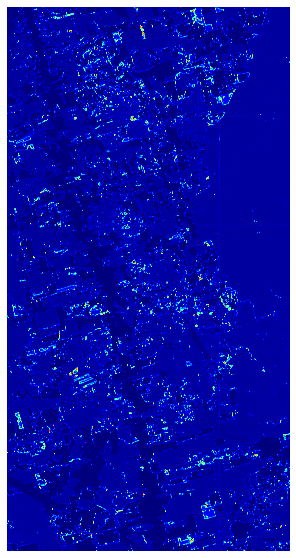

In [82]:
trainer.logger.plotFigure(trainer.uncertainty_to_show, 
            name=trainer.dataset.site + trainer.title_name + ' uncertainty evidential learning.png', figsize=(10,10), cmap='jet', savefig=True)

ic| trainer.dataset.previewLims1: array([2200, 3200, 6900, 7900])
    trainer.dataset.previewLims2: array([ 500, 1500, 3500, 4500])
ic| np.unique(trainer.mask_amazon_ts[lims[0]:lims[1], lims[2]:lims[3]]): array([1], dtype=uint8)
ic| np.unique(trainer.mask_amazon_ts[lims[0]:lims[1], lims[2]:lims[3]], return_counts=True): (array([1], dtype=uint8), array([1000000], dtype=int64))
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


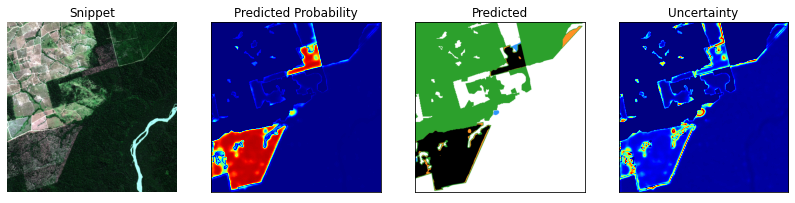

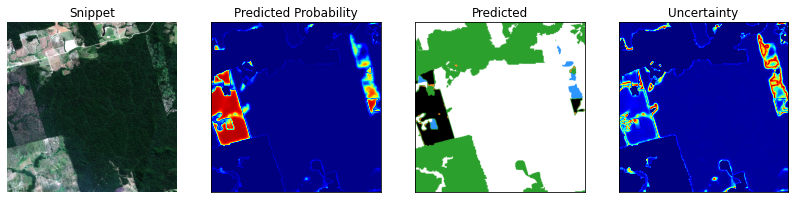

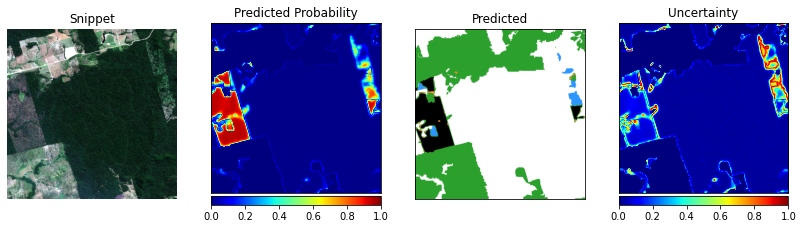

In [83]:
trainer.logger.plotCropSample(trainer)

In [84]:
trainer.logger.getStats(trainer.uncertainty)

ic| np.min(value): 0.013856342
    np.mean(value): 0.061989293
    np.max(value): 1.0


In [85]:
import matplotlib.tri as tri

corners = np.array([[0, 0], [1, 0], [0.5, 0.75**0.5]])
AREA = 0.5 * 1 * 0.75**0.5
triangle = tri.Triangulation(corners[:, 0], corners[:, 1])

# For each corner of the triangle, the pair of other corners
pairs = [corners[np.roll(range(3), -i)[1:]] for i in range(3)]
# The area of the triangle formed by point xy and another pair or points
tri_area = lambda xy, pair: 0.5 * np.linalg.norm(np.cross(*(pair - xy)))

def xy2bc(xy, tol=1.e-4):
    '''Converts 2D Cartesian coordinates to barycentric.'''
    coords = np.array([tri_area(xy, p) for p in pairs]) / AREA
    return np.clip(coords, tol, 1.0 - tol)

class Dirichlet(object):
    def __init__(self, alpha):
        from math import gamma
        from operator import mul
        self._alpha = np.array(alpha)
        self._coef = gamma(np.sum(self._alpha)) / \
                           np.multiply.reduce([gamma(a) for a in self._alpha])
    def pdf(self, x):
        '''Returns pdf value for `x`.'''
        from operator import mul
        return self._coef * np.multiply.reduce([xx ** (aa - 1)
                                               for (xx, aa)in zip(x, self._alpha)])
    
def draw_pdf_contours(dist, nlevels=200, subdiv=8, **kwargs):
    import math

    refiner = tri.UniformTriRefiner(triangle)
    trimesh = refiner.refine_triangulation(subdiv=subdiv)
    pvals = [dist.pdf(xy2bc(xy)) for xy in zip(trimesh.x, trimesh.y)]

    plt.tricontourf(trimesh, pvals, nlevels, cmap='jet', **kwargs)
    plt.axis('equal')
    plt.xlim(0, 1)
    plt.ylim(0, 0.75**0.5)
    plt.axis('off')
def getMassFcn(self, alpha = [5, 5, 5]):
        draw_pdf_contours(Dirichlet(alpha))


In [86]:

import types

trainer.getMassFcn = types.MethodType(getMassFcn, trainer)


In [87]:
from sklearn import metrics
def getUncertaintyMetrics(self):
    predicted_thresholded = np.zeros_like(self.uncertainty).astype(np.int8)
    predicted_thresholded[self.uncertainty * 2.8 >= np.max(self.predicted_test,axis=-1)] = 1
    print(np.unique(predicted_thresholded, return_counts=True))

    predicted_test_classified_correct = self.predicted_test[
            predicted_thresholded == 0]
    label_current_deforestation_test_classified_correct = self.label_mask_current_deforestation_test[
            predicted_thresholded == 0]


    predicted_test_classified_incorrect = self.predicted_test[
            predicted_thresholded == 1]
    label_current_deforestation_test_classified_incorrect = self.label_mask_current_deforestation_test[
            predicted_thresholded == 1]

    uncertainty_classified_correct = self.uncertainty[
            predicted_thresholded == 0]
    uncertainty_classified_incorrect = self.uncertainty[
            predicted_thresholded == 1]
    print(np.min(uncertainty_classified_correct), np.mean(uncertainty_classified_correct), np.max(uncertainty_classified_correct))
    print(np.min(uncertainty_classified_incorrect), np.mean(uncertainty_classified_incorrect), np.max(uncertainty_classified_incorrect))

    print(label_current_deforestation_test_classified_correct.shape,
            predicted_test_classified_correct.shape)
    cm_correct = metrics.confusion_matrix(
            label_current_deforestation_test_classified_correct,
            predicted_test_classified_correct)
    print("cm_correct", cm_correct)

    TN_L = cm_correct[0,0]
    FN_L = cm_correct[1,0]
    TP_L = cm_correct[1,1]
    FP_L = cm_correct[0,1]

    ic(label_current_deforestation_test_classified_incorrect.shape,
            predicted_test_classified_incorrect.shape)

    cm_incorrect = metrics.confusion_matrix(
            label_current_deforestation_test_classified_incorrect,
            predicted_test_classified_incorrect)

    print("cm_incorrect", cm_incorrect)

    if cm_incorrect.shape[0] != 2: 
            ic(np.all(label_current_deforestation_test_classified_incorrect) == 0) 
            ic(np.all(predicted_test_classified_incorrect) == 0) 
            
            precision_L = np.nan 
            recall_L = np.nan 
            recall_Ltotal = np.nan 
            AA = len(label_current_deforestation_test_classified_incorrect) / len(self.label_mask_current_deforestation_test) 
            precision_H = np.nan 
            recall_H = np.nan 
    else:
                    
            TN_H = cm_incorrect[0,0]
            FN_H = cm_incorrect[1,0]
            TP_H = cm_incorrect[1,1]
            FP_H = cm_incorrect[0,1]
            
            precision_L = TP_L / (TP_L + FP_L)
            recall_L = TP_L / (TP_L + FN_L)
            
            precision_H = TP_H / (TP_H + FP_H)
            recall_H = TP_H / (TP_H + FN_H)
            
            recall_Ltotal = TP_L / (TP_L + FN_L + TP_H + FN_H)
            ic((TP_H + FN_H + FP_H + TN_H), len(self.label_mask_current_deforestation_test))
            AA = (TP_H + FN_H + FP_H + TN_H) / len(self.label_mask_current_deforestation_test)
            ic((TP_H + FN_H + FP_H + TN_H), len(self.label_mask_current_deforestation_test))


    self.m = {'precision_L': precision_L,
            'recall_L': recall_L,
            'recall_Ltotal': recall_Ltotal,
            'AA': AA,
            'precision_H': precision_H,
            'recall_H': recall_H}

    self.m['f1_L'] = 2*self.m['precision_L']*self.m['recall_L']/(self.m['precision_L']+self.m['recall_L'])
    self.m['f1_H'] = 2*self.m['precision_H']*self.m['recall_H']/(self.m['precision_H']+self.m['recall_H'])


In [88]:

import types

trainer.getUncertaintyMetrics = types.MethodType(getUncertaintyMetrics, trainer)


In [89]:
trainer.getUncertaintyMetrics()

(array([0, 1], dtype=int8), array([52113000,  2034698], dtype=int64))
0.013856342 0.040116873 0.35714263
0.35714316 0.62218547 1.0
(52113000,) (52113000,)


ic| label_current_deforestation_test_classified_incorrect.shape: (2034698,)
    predicted_test_classified_incorrect.shape: (2034698,)


cm_correct [[51583248    21766]
 [   28558   479428]]


ic| TP_H + FN_H + FP_H + TN_H: 2034698
    len(self.label_mask_current_deforestation_test): 54147698
ic| TP_H + FN_H + FP_H + TN_H: 2034698
    len(self.label_mask_current_deforestation_test): 54147698


cm_incorrect [[1749337   55414]
 [  94052  135895]]


In [90]:
trainer.m

{'precision_L': 0.956571706764247,
 'recall_L': 0.9437819152496328,
 'recall_Ltotal': 0.6496904190488838,
 'AA': 0.03757681443816873,
 'precision_H': 0.7103429530236424,
 'recall_H': 0.5909840093586783,
 'f1_L': 0.9501337719732851,
 'f1_H': 0.6451896234118921}

In [91]:
print(trainer.uncertainty.shape, trainer.predicted_test.shape)
print(trainer.uncertainty.dtype, trainer.predicted_test.dtype)
print(np.unique(trainer.predicted_test))
print(trainer.label_mask_current_deforestation_test.shape)


(54147698,) (54147698,)
float32 float32
[0. 1.]
(54147698,)


In [92]:
trainer.mean_prob[trainer.mask_amazon_ts == 1].shape

(81558000,)

In [93]:
uncertainty_test_correct = trainer.uncertainty[trainer.predicted_test == trainer.label_mask_current_deforestation_test]
uncertainty_test_incorrect = trainer.uncertainty[trainer.predicted_test != trainer.label_mask_current_deforestation_test]

predicted_test_correct = trainer.uncertainty[trainer.predicted_test == trainer.label_mask_current_deforestation_test]
uncertainty_test_incorrect = trainer.uncertainty[trainer.predicted_test != trainer.label_mask_current_deforestation_test]


In [94]:
print(np.min(uncertainty_test_correct), np.mean(uncertainty_test_correct), np.max(uncertainty_test_correct))
print(np.min(uncertainty_test_incorrect), np.mean(uncertainty_test_incorrect), np.max(uncertainty_test_incorrect))


0.013856342 0.060037352 1.0
0.02555375 0.58907765 1.0


In [97]:
trainer.alpha_reconstructed.shape

(17760, 9216, 3)

In [112]:
trainer.alpha_unpad = trainer.alpha_reconstructed[:trainer.label_mask.shape[0], :trainer.label_mask.shape[1]]

In [113]:
trainer.alpha_unpad.shape

(17730, 9200, 3)

In [116]:
print(np.min(trainer.alpha_unpad), np.mean(trainer.alpha_unpad), np.max(trainer.alpha_unpad))

1.0 28.390984 214.50735


In [108]:
trainer.predicted_unpad.shape

(17730, 9200)

In [140]:
trainer.label_mask.shape

(17730, 9200)

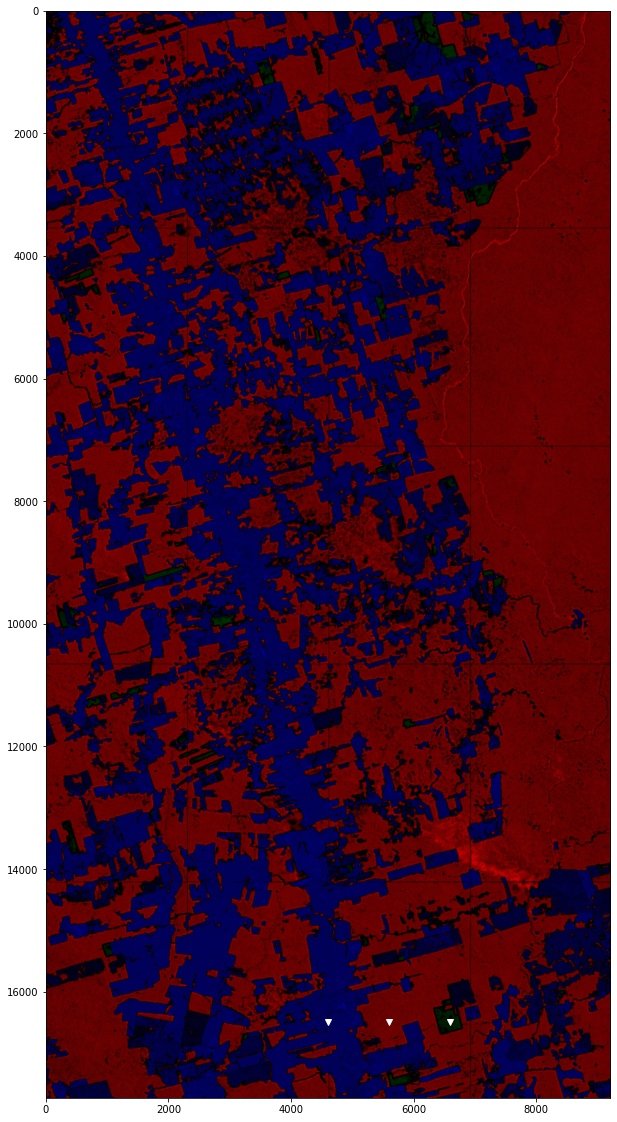

In [136]:
fig = plt.figure(figsize=(20,20))

plt.imshow(trainer.alpha_unpad.astype(np.uint8))
plt.plot(6600, 16500, marker='v', color="white")
plt.plot(5600, 16500, marker='v', color="white")
plt.plot(4600, 16500, marker='v', color="white")

In [ ]:
[2200, 3200, 6900, 7900]

In [142]:
row, col = (16500, 5600)


In [141]:
# trainer.predicted_unpad[2500, 7300]

# trainer.predicted_unpad[16500, 6600]
# trainer.predicted_unpad[16500, 5600]

trainer.predicted_unpad[row, col]
trainer.label_mask[row, col]


2

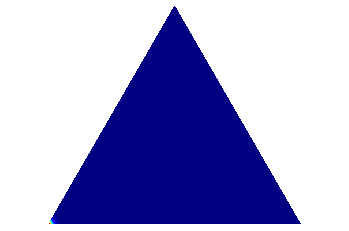

In [134]:
# trainer.getMassFcn(trainer.alpha_reconstructed[2500,7300])
# trainer.getMassFcn(trainer.alpha_unpad[16500,6600])
trainer.getMassFcn(trainer.alpha_unpad[16500,5600])


In [ ]:
trainer.m

{'precision_L': 0.956571706764247,
 'recall_L': 0.9437819152496328,
 'recall_Ltotal': 0.6496904190488838,
 'AA': 0.03757681443816873,
 'precision_H': 0.7103429530236424,
 'recall_H': 0.5909840093586783,
 'f1_L': 0.9501337719732851,
 'f1_H': 0.6451896234118921}

In [ ]:
trainer.getUncertaintyAAValues()

ic| self.uncertainty.shape: (54147698,)
    self.label_mask_current_deforestation_test.shape: (54147698,)


[0.13, 0.15, 0.2, 0.225, 0.25, 0.27, 0.3, 0.34, 0.36, 0.45, 0.55, 0.65, 0.8]
threshold 0.13
(50097636,) (50097636,)


ic| label_current_deforestation_test_classified_incorrect.shape: (4050062,)
    predicted_test_classified_incorrect.shape: (4050062,)


cm_correct [[49806418      202]
 [   16742   274274]]


ic| TP_H + FN_H + FP_H + TN_H: 4050062
    len(label_mask_current_deforestation_test): 54147698
ic| TP_H + FN_H + FP_H + TN_H: 4050062
    len(label_mask_current_deforestation_test): 54147698


cm_incorrect [[3526167   76978]
 [ 105868  341049]]
[0.99926405 0.94247052 0.37167873 0.07479657 0.815854   0.76311485
 0.04495838]
threshold 0.15
(50401261,) (50401261,)


ic| label_current_deforestation_test_classified_incorrect.shape: (3746437,)
    predicted_test_classified_incorrect.shape: (3746437,)


cm_correct [[50070117      494]
 [   18073   312577]]


ic| TP_H + FN_H + FP_H + TN_H: 3746437
    len(label_mask_current_deforestation_test): 54147698
ic| TP_H + FN_H + FP_H + TN_H: 3746437
    len(label_mask_current_deforestation_test): 54147698


cm_incorrect [[3262468   76686]
 [ 104537  302746]]
[0.99842208 0.945341   0.42358453 0.06918922 0.79789264 0.7433308
 0.04813355]
threshold 0.2
(50964065,) (50964065,)


ic| label_current_deforestation_test_classified_incorrect.shape: (3183633,)
    predicted_test_classified_incorrect.shape: (3183633,)


cm_correct [[50567734     2244]
 [   21073   373014]]


ic| TP_H + FN_H + FP_H + TN_H: 3183633
    len(label_mask_current_deforestation_test): 54147698
ic| TP_H + FN_H + FP_H + TN_H: 3183633
    len(label_mask_current_deforestation_test): 54147698


cm_incorrect [[2764851   74936]
 [ 101537  242309]]
[0.99402011 0.94652704 0.50548492 0.05879535 0.76379139 0.70470211
 0.0550283 ]
threshold 0.225
(51187580,) (51187580,)


ic| label_current_deforestation_test_classified_incorrect.shape: (2960118,)
    predicted_test_classified_incorrect.shape: (2960118,)


cm_correct [[50767236     3736]
 [   22521   394087]]


ic| TP_H + FN_H + FP_H + TN_H: 2960118
    len(label_mask_current_deforestation_test): 54147698
ic| TP_H + FN_H + FP_H + TN_H: 2960118
    len(label_mask_current_deforestation_test): 54147698


cm_incorrect [[2565349   73444]
 [ 100089  221236]]
[0.99060889 0.94594199 0.53404171 0.05466748 0.75076693 0.68851163
 0.05810824]
threshold 0.25
(51390679,) (51390679,)


ic| label_current_deforestation_test_classified_incorrect.shape: (2757019,)
    predicted_test_classified_incorrect.shape: (2757019,)


cm_correct [[50948617     5714]
 [   23821   412527]]


ic| TP_H + FN_H + FP_H + TN_H: 2757019
    len(label_mask_current_deforestation_test): 54147698
ic| TP_H + FN_H + FP_H + TN_H: 2757019
    len(label_mask_current_deforestation_test): 54147698


cm_incorrect [[2383968   71466]
 [  98789  202796]]
[0.98633802 0.94540825 0.55903043 0.05091664 0.73942435 0.67243397
 0.06109876]
threshold 0.27
(51542925,) (51542925,)


ic| label_current_deforestation_test_classified_incorrect.shape: (2604773,)
    predicted_test_classified_incorrect.shape: (2604773,)


cm_correct [[51083710     8263]
 [   24737   426215]]


ic| TP_H + FN_H + FP_H + TN_H: 2604773
    len(label_mask_current_deforestation_test): 54147698
ic| TP_H + FN_H + FP_H + TN_H: 2604773
    len(label_mask_current_deforestation_test): 54147698


cm_incorrect [[2248875   68917]
 [  97873  189108]]
[0.98098178 0.94514494 0.57757954 0.04810496 0.73290573 0.65895652
 0.06323137]
threshold 0.3
(51755833,) (51755833,)


ic| label_current_deforestation_test_classified_incorrect.shape: (2391865,)
    predicted_test_classified_incorrect.shape: (2391865,)


cm_correct [[51271397    12721]
 [   26114   445601]]


ic| TP_H + FN_H + FP_H + TN_H: 2391865
    len(label_mask_current_deforestation_test): 54147698
ic| TP_H + FN_H + FP_H + TN_H: 2391865
    len(label_mask_current_deforestation_test): 54147698


cm_incorrect [[2061188   64459]
 [  96496  169722]]
[0.9722444  0.9446403  0.60385021 0.04417298 0.7247471  0.63753014
 0.06621755]
threshold 0.34
(52010889,) (52010889,)


ic| label_current_deforestation_test_classified_incorrect.shape: (2136809,)
    predicted_test_classified_incorrect.shape: (2136809,)


cm_correct [[51494331    19132]
 [   27835   469591]]


ic| TP_H + FN_H + FP_H + TN_H: 2136809
    len(label_mask_current_deforestation_test): 54147698
ic| TP_H + FN_H + FP_H + TN_H: 2136809
    len(label_mask_current_deforestation_test): 54147698


cm_incorrect [[1838254   58048]
 [  94775  145732]]
[0.96085308 0.94404193 0.63635994 0.0394626  0.71514378 0.60593663
 0.06998108]
threshold 0.36
(52129862,) (52129862,)


ic| label_current_deforestation_test_classified_incorrect.shape: (2017836,)
    predicted_test_classified_incorrect.shape: (2017836,)


cm_correct [[51598066    22181]
 [   28676   480939]]


ic| TP_H + FN_H + FP_H + TN_H: 2017836
    len(label_mask_current_deforestation_test): 54147698
ic| TP_H + FN_H + FP_H + TN_H: 2017836
    len(label_mask_current_deforestation_test): 54147698


cm_incorrect [[1734519   54999]
 [  93934  134384]]
[0.9559131  0.94373007 0.65173803 0.03726541 0.70958851 0.58858259
 0.07199377]
threshold 0.45
(52610008,) (52610008,)


ic| label_current_deforestation_test_classified_incorrect.shape: (1537690,)
    predicted_test_classified_incorrect.shape: (1537690,)
ic| TP_H + FN_H + FP_H + TN_H: 1537690
    len(label_mask_current_deforestation_test): 54147698
ic| TP_H + FN_H 

cm_correct [[52016475    35072]
 [   32623   525838]]
cm_incorrect [[1316110   42108]
 [  89987   89485]]


+ FP_H + TN_H: 1537690
    len(label_mask_current_deforestation_test): 54147698


[0.93747303 0.9415841  0.71258231 0.02839807 0.68001337 0.49860145
 0.08228244]
threshold 0.55
(53019774,) (53019774,)


ic| label_current_deforestation_test_classified_incorrect.shape: (1127924,)
    predicted_test_classified_incorrect.shape: (1127924,)
ic| TP_H + FN_H + FP_H + TN_H: 1127924
    len(label_mask_current_deforestation_test): 54147698
ic| TP_H + FN_H + FP_H + TN_H: 1127924
    len(label_mask_current_deforestation_test): 54147698


cm_correct [[52367842    50289]
 [   36941   564702]]
cm_incorrect [[964743  26891]
 [ 85669  50621]]
[0.91822807 0.9385998  0.76524834 0.02083051 0.65307307 0.37142123
 0.09263023]
threshold 0.65
(53332776,) (53332776,)


ic| label_current_deforestation_test_classified_incorrect.shape: (814922,)
    predicted_test_classified_incorrect.shape: (814922,)
ic| TP_H + FN_H + FP_H + TN_H: 814922
    len(label_mask_current_deforestation_test): 54147698
ic| TP_H + FN_H + FP_H + TN_H: 814922
    len(label_mask_current_deforestation_test): 54147698


cm_correct [[52635540    63518]
 [   41415   592303]]
cm_incorrect [[697045  13662]
 [ 81195  23020]]
[0.90314735 0.93464759 0.80265146 0.01504998 0.62755575 0.22088951
 0.10312169]
threshold 0.8
(53702091,) (53702091,)


ic| label_current_deforestation_test_classified_incorrect.shape: (445607,)
    predicted_test_classified_incorrect.shape: (445607,)
d:\Jorge\deforestation_uncertainty\src\metrics.py:295: RuntimeWarning: invalid value encountered in longlong_scalars
  precision_H = TP_H / (TP_H + FP_H)
ic| TP_H + FN_H + FP_H + TN_H: 445607
    len(label_mask_current_deforestation_test): 54147698
ic| TP_H + FN_H + FP_H + TN_H: 445607
    len(label_mask_current_deforestation_test): 54147698


cm_correct [[52945425    77180]
 [   64163   615323]]
cm_incorrect [[387160      0]
 [ 58447      0]]
[0.88854922 0.90557127 0.8338467  0.00822947        nan 0.
 0.09957748]


In [ ]:
trainer.getUncertaintyAAAuditedValues()

ic| self.uncertainty.shape: (54147698,)
    self.label_mask_current_deforestation_test.shape: (54147698,)


threshold 0.13
(54147698,) (54147698,)
cm_audited [[53409563      202]
 [   16742   721191]]
[0.99971999 0.9773123 ]
threshold 0.15
(54147698,) (54147698,)
cm_audited [[53409271      494]
 [   18073   719860]]
[0.99931423 0.97550862]
threshold 0.2
(54147698,) (54147698,)
cm_audited [[53407521     2244]
 [   21073   716860]]
[0.99687945 0.97144321]
threshold 0.225
(54147698,) (54147698,)
cm_audited [[53406029     3736]
 [   22521   715412]]
[0.99480496 0.96948097]
threshold 0.25
(54147698,) (54147698,)
cm_audited [[53404051     5714]
 [   23821   714112]]
[0.99206197 0.96771929]
threshold 0.27
(54147698,) (54147698,)
cm_audited [[53401502     8263]
 [   24737   713196]]
[0.98854682 0.96647799]
threshold 0.3
(54147698,) (54147698,)
cm_audited [[53397044    12721]
 [   26114   711819]]
[0.98244265 0.96461196]
threshold 0.34
(54147698,) (54147698,)
cm_audited [[53390633    19132]
 [   27835   710098]]
[0.97376411 0.96227977]
threshold 0.36
(54147698,) (54147698,)
cm_audited [[53387584    2

ic| metric_values_audited: array([[0.99971999, 0.9773123 ],
                                  [0.99931423, 0.97550862],
                                  [0.99687945, 0.97144321],
                                  [0.99480496, 0.96948097],
                                  [0.99206197, 0.96771929],
                                  [0.98854682, 0.96647799],
                                  [0.98244265, 0.96461196],
                                  [0.97376411, 0.96227977],
                                  [0.9696748 , 0.9611401 ],
                                  [0.95262986, 0.95579138],
                                  [0.93306233, 0.9499399 ],
                                  [0.91642764, 0.94387702],
                                  [0.89722352, 0.91305037]])


cm_audited [[53332585    77180]
 [   64163   673770]]
[0.89722352 0.91305037]


In [ ]:
trainer.setPlotLimsForUncertaintyAA()

In [ ]:

def plotUncertaintyAA(self):

    fig, (ax1, ax2, ax3) = plt.subplots(1, 3)
    fig.set_figheight(5)
    fig.set_figwidth(15)
    ax1.plot(self.m['AA']*100, self.m['precision_L']*100, 'C3-', label="Precision Low Uncertainty")
    ax1.plot(self.m['AA']*100, self.m['recall_L']*100, 'C3--', label="Recall Low Uncertainty")
    ax1.plot(self.m['AA']*100, self.m['precision_H']*100, 'C0-', label="Precision High Uncertainty")
    ax1.plot(self.m['AA']*100, self.m['recall_H']*100, 'C0--', label="Recall High Uncertainty")
    ax1.plot(self.m['AA']*100, self.m_audited['precision']*100, 'C2-', label="Precision Audited")
    ax1.plot(self.m['AA']*100, self.m_audited['recall']*100, 'C2--', label="Recall Audited")

    ax1.legend(loc="lower right")
    ax1.set_ylabel('Precision/recall (%)')
    ax1.set_xlabel('Audit Area (%)')
    ax1.set_ylim(self.ylim)
    ax1.set_xlim(self.xlim)
    ax1.grid()

    xs = [0, 120]
    ax1.vlines(x = 3, ymin = 0, ymax = max(xs),
            colors = (0.2, 0.2, 0.2),
            label = 'vline_multiple - full height')

    ax2.plot(range(int(self.xlim[0]), int(self.xlim[1] + 2)), 
        np.ones(int(self.xlim[1] + 2)) * self.f1, 
        'C1:', label="F1 No Uncertainty")

    ax2.plot(self.m['AA']*100, self.m['f1_L']*100, 'C3-', label="F1 Low Uncertainty")
    ax2.plot(self.m['AA']*100, self.m['f1_H']*100, 'C0-', label="F1 High Uncertainty")
    ax2.plot(self.m['AA']*100, self.m_audited['f1']*100, 'C2-', label="F1 Audited")

    ax2.legend(loc="lower right")
    ax2.set_ylabel('F1 score (%)')
    ax2.set_xlabel('Audit Area (%)')
    ax2.set_ylim(self.ylim)
    ax2.set_xlim(self.xlim)

    ax2.grid()

    xs = [0, 120]
    ax2.vlines(x = 3, ymin = 0, ymax = max(xs),
            colors = (0.2, 0.2, 0.2),
            label = '3% AA')

    ax3.plot(np.asarray(self.threshold_list), self.m['AA']*100, label="AA")
    ax3.set_ylabel('Audit Area (%)')
    ax3.set_xlabel('Uncertainty Threshold')
    ax3.grid()
    ax3.set_ylim(self.xlim)

    self.xlim_adjusted = ax3.get_xlim()
    ax3.hlines(y = 3, xmin = self.xlim_adjusted[0], xmax = self.xlim_adjusted[1],
            colors = (0.2, 0.2, 0.2),
            label = '3% AA')

    ax3.set_xlim(self.xlim_adjusted)

    # if save_figures == True:
    if True:
        plt.savefig('output/figures/recall_precision_f1_AA.png', dpi=150, bbox_inches='tight')

def plotUEO(self): 

    plt.plot(self.m['AA']*100, self.m['UEO'], label="UEO") 
    plt.grid() 
    plt.xlabel('Audit Area (%)') 
    plt.ylabel('UEO (%)') 
    plt.xlim(self.xlim)
    plt.ylim([0, 0.4])

import types

trainer.plotUncertaintyAA = types.MethodType(plotUncertaintyAA, trainer)
trainer.plotUEO = types.MethodType(plotUEO, trainer)


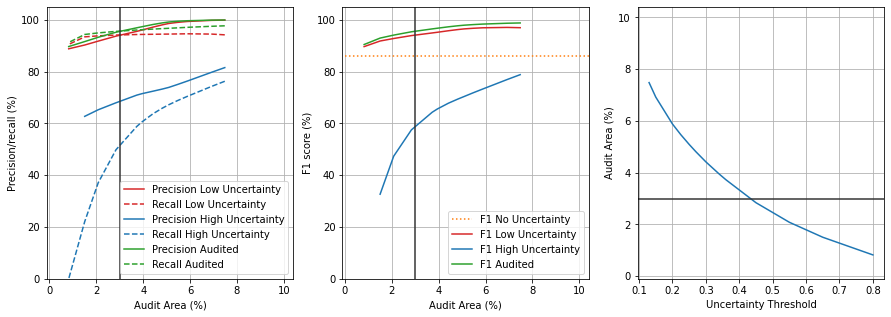

In [ ]:
trainer.plotUncertaintyAA()

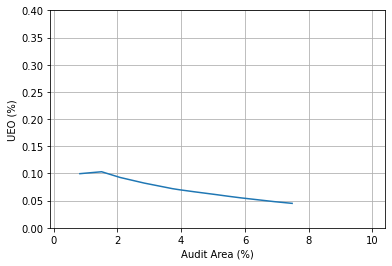

In [ ]:
trainer.plotUEO()

In [ ]:
trainer.getOptimalUncertaintyThreshold()

ic| bounds: (0.0015, 0.9985)
c:\Users\jchamorro\Anaconda3\envs\tf2\lib\site-packages\scipy\optimize\_minimize.py:783: RuntimeWarning: Method 'bounded' does not support relative tolerance in x; defaulting to absolute tolerance.
  warn("Method 'bounded' does not support relative tolerance in x; "


0.38232011321635484
threshold 0.38232011321635484
(52258908,) (52258908,)


ic| label_current_deforestation_test_classified_incorrect.shape: (1888790,)
    predicted_test_classified_incorrect.shape: (1888790,)


cm_correct [[51710951    25517]
 [   29636   492804]]


ic| TP_H + FN_H + FP_H + TN_H: 1888790
    len(label_mask_current_deforestation_test): 54147698
ic| TP_H + FN_H + FP_H + TN_H: 1888790
    len(label_mask_current_deforestation_test): 54147698


cm_incorrect [[1621634   51663]
 [  92974  122519]]
[0.95076989 0.94327387 0.66781673 0.03488218 0.70339645 0.56855211
 0.07440393]
0.6176798867836452
threshold 0.6176798867836452
(53239873,) (53239873,)


ic| label_current_deforestation_test_classified_incorrect.shape: (907825,)
    predicted_test_classified_incorrect.shape: (907825,)
ic| TP_H + FN_H + FP_H + TN_H: 907825
    len(label_mask_current_deforestation_test): 54147698
ic| TP_H + FN_H + FP_H + TN_H: 907825
    len(label_mask_current_deforestation_test): 54147698


cm_correct [[52556643    59379]
 [   39785   584066]]
cm_incorrect [[775942  17801]
 [ 82825  31257]]
[0.90771705 0.93622676 0.7914892  0.01676572 0.63714379 0.27398713
 0.09992761]
0.23685977356729035
threshold 0.23685977356729035
(51285995,) (51285995,)


ic| label_current_deforestation_test_classified_incorrect.shape: (2861703,)
    predicted_test_classified_incorrect.shape: (2861703,)


cm_correct [[50855159     4622]
 [   23147   403067]]


ic| TP_H + FN_H + FP_H + TN_H: 2861703
    len(label_mask_current_deforestation_test): 54147698
ic| TP_H + FN_H + FP_H + TN_H: 2861703
    len(label_mask_current_deforestation_test): 54147698


cm_incorrect [[2477426   72558]
 [  99463  212256]]
[0.98866293 0.9456916  0.54621083 0.05284995 0.74524426 0.68092096
 0.05953371]
0.45750587539724097
threshold 0.45750587539724097
(52645015,) (52645015,)


In [ ]:
trainer.getUncertaintyMetricsFromOptimalThreshold()

threshold 0.9984340913595322


ic| label_current_deforestation_test_classified_incorrect.shape: (53089172,)
    predicted_test_classified_incorrect.shape: (53089172,)


(969026,) (969026,)
cm_correct [[165785 171365]
 [ 24792 607084]]


d:\Jorge\deforestation_uncertainty\src\metrics.py:295: RuntimeWarning: invalid value encountered in longlong_scalars
  precision_H = TP_H / (TP_H + FP_H)
ic| TP_H + FN_H + FP_H + TN_H: 53089172
    len(label_mask_current_deforestation_test): 54058198
ic| TP_H + FN_H + FP_H + TN_H: 53089172
    len(label_mask_current_deforestation_test): 54058198


cm_incorrect [[52992502        0]
 [   96670        0]]
[0.77986355 0.96076445 0.83328163 0.98207439        nan 0.
 0.0018142 ]
threshold 0.9984340913595322
(54058198,) (54058198,)


ic| self.m_optimal: {'AA': array([0.98207439]),
                     'UEO': array([0.0018142]),
                     'f1': 80.57,
                     'f1_H': array([nan]),
                     'f1_L': array([0.86091362]),
                     'precision_H': array([nan]),
                     'precision_L': array([0.77986355]),
                     'recall_H': array([0.]),
                     'recall_L': array([0.96076445]),
                     'recall_Ltotal': array([0.83328163])}
ic| self.m_audited_optimal: {'f1': array([0.87768206]),
                             'precision': array([0.80418092]),
                             'recall': array([0.96597058])}


cm_audited [[53158287   171365]
 [   24792   703754]]
[0.80418092 0.96597058]


{'metrics': {'precision_L': array([0.77986355]),
  'recall_L': array([0.96076445]),
  'recall_Ltotal': array([0.83328163]),
  'AA': array([0.98207439]),
  'precision_H': array([nan]),
  'recall_H': array([0.]),
  'UEO': array([0.0018142]),
  'f1_L': array([0.86091362]),
  'f1_H': array([nan]),
  'f1': 80.57},
 'metrics_audited': {'precision': array([0.80418092]),
  'recall': array([0.96597058]),
  'f1': array([0.87768206])},
 'exp': 186}